# Transfer learning with data augmentation

### Using VGG16 pre-trained on ImageNet to classify on Clatech101

### Data processing with keras.
 Documentaiton for *ImageDataGenerator* and *flow_from_directory*: https://keras.io/api/preprocessing/image/

In [18]:
# Image processing from local files

from keras.preprocessing.image import ImageDataGenerator
image_size = 224


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  )

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32
)


# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=False
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Found 6782 images belonging to 102 classes.
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


## Building the model

We define the necessary packages needed. Next we define the base model to be the VGG16 model pre-trained on ImageNet.
Documentation for the VGG16 model: https://keras.io/api/applications/vgg/#vgg16-function
Documentation for ImageNet: http://www.image-net.org/

Following this, we modify the output layer of VGG16 to fit the Caltech101 dataset. Next, we set the already pre-trained weights of VGG16 to untrainable, while only having the softmax output layer trainable. This saves a lot of time when training the network. Documentation for trainable/untrainable layers: https://keras.io/guides/transfer_learning/

In [2]:
# Include all packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers


In [4]:
# Base model = VGG16

base_model = VGG16(weights='imagenet',
                  include_top=True,
                  )

base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Modify VGG16 model to fit Caltech101.

input_layer = base_model.input

new_classification_layer = Dense(102, activation='softmax')

output_layer = new_classification_layer(base_model.layers[-2].output)


modified_VGG16 = Model(input_layer, output_layer)

modified_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Make output layer trainabel. All other layers remains with same weights as for the pretrained VGG16 model.

for i, layer in enumerate(modified_VGG16.layers[:-1]):
    layer.trainable = False
    
for i, layer in enumerate(modified_VGG16.layers[-1:]):
    layer.trainable = True
    
modified_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Training the model

Now we want to train the model. Here we need to compile the model with a loss function, optimizer and performance metrics. Then the model is trained on the training dataset and validated on the validation dataset with model.fit(). Documentaiton on compile and fit: https://keras.io/api/models/model_training_apis/

In [7]:
modified_VGG16.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['accuracy', 'top_k_categorical_accuracy'])

history = modified_VGG16.fit(train_dataset,
                  validation_data=val_dataset,
                  epochs=30)

Epoch 1/30
212/212 [==============================] - 564s 3s/step - loss: 3.9070 - acc: 0.1867 - top_k_categorical_accuracy: 0.3613 - val_loss: 3.4152 - val_acc: 0.2746 - val_top_k_categorical_accuracy: 0.4385
Epoch 2/30
212/212 [==============================] - 516s 2s/step - loss: 3.2542 - acc: 0.3035 - top_k_categorical_accuracy: 0.5010 - val_loss: 2.8929 - val_acc: 0.3347 - val_top_k_categorical_accuracy: 0.5963
Epoch 3/30
212/212 [==============================] - 516s 2s/step - loss: 2.8543 - acc: 0.3689 - top_k_categorical_accuracy: 0.5969 - val_loss: 2.5465 - val_acc: 0.3859 - val_top_k_categorical_accuracy: 0.6913
Epoch 4/30
212/212 [==============================] - 516s 2s/step - loss: 2.5680 - acc: 0.4220 - top_k_categorical_accuracy: 0.6654 - val_loss: 2.3188 - val_acc: 0.4324 - val_top_k_categorical_accuracy: 0.7172
Epoch 5/30
212/212 [==============================] - 517s 2s/step - loss: 2.3485 - acc: 0.4625 - top_k_categorical_accuracy: 0.7141 - val_loss: 2.0883 - va

## After the model is finished training we store the weights and the history of the model

This info is stored such that we can evaluate to model without having to repeatedly train it. 

The weights are saved through model.save. Documentation for the save function: https://www.tensorflow.org/guide/keras/save_and_serialize

The history is stored with numpy as this is convenient given the dictionary structure. Documentaion on numpy.save: https://numpy.org/devdocs/reference/generated/numpy.save.html

In [8]:
modified_VGG16.save("./model_weights/Transfer_learning_VGG16_data_augmentation.h5")

In [9]:
import numpy as np
data_history_training = history.history

np.save('./model_histories/Transfer_learning_VGG16_data_augmentation.npy', data_history_training)

## Now that the model is saved, we can retrieve the model and history to test the model and plot results

The model is loaded with the in-built keras function. Documentation: https://www.tensorflow.org/guide/keras/save_and_serialize

We evaluate the model with the evaluate function. This gives loss and the performance metrics specified in compile. Documentation: https://keras.io/api/models/model_training_apis/

The history for training is retrieved with numpy.load. Documentation: https://numpy.org/doc/stable/reference/generated/numpy.load.html

Finally, the history is visualized with matplotlib. Documentation: https://matplotlib.org/



In [11]:
# Run model on test set from saved model

from tensorflow import keras

reconstructed_model_VGG16 = keras.models.load_model("./model_weights/Transfer_learning_VGG16_data_augmentation.h5")
reconstructed_model_VGG16.evaluate(test_dataset)

29/29 [==============================] - 48s 2s/step - loss: 1.1025 - acc: 0.7238 - top_k_categorical_accuracy: 0.8886


[1.1024912266253397, 0.72383076, 0.8886414]

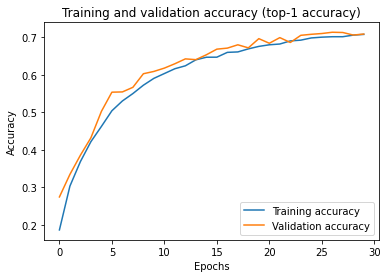

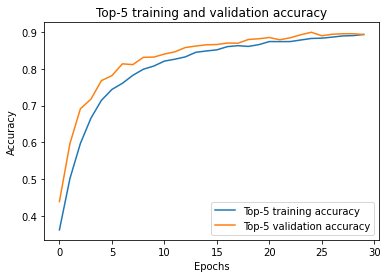

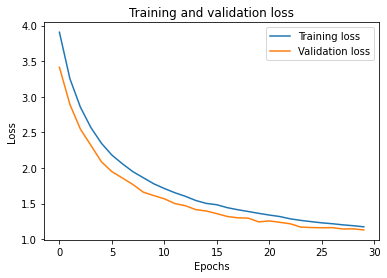

In [12]:
import numpy as np
reconstructed_history_VGG16 = np.load('./model_histories/Transfer_learning_VGG16_data_augmentation.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history_VGG16['acc']
val_acc = reconstructed_history_VGG16['val_acc']

loss = reconstructed_history_VGG16['loss']
val_loss = reconstructed_history_VGG16['val_loss']

top_5_acc = reconstructed_history_VGG16['top_k_categorical_accuracy']
top_5_val_acc = reconstructed_history_VGG16['val_top_k_categorical_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy (top-1 accuracy)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(epochs, top_5_acc, label='Top-5 training accuracy')
plt.plot(epochs, top_5_val_acc, label='Top-5 validation accuracy')
plt.title('Top-5 training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


## Lastly, we use the model to predict the output on the test data

The predict function returns the softmax output defined in the model. Hence, the output from every image is a array of shape (102,). Using the numpy.argmax function gives the most probable class. Documentation on predict: https://keras.io/api/models/model_training_apis/

Finally, we use the sklearn library to generate the classification report. Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [13]:
import sklearn
from sklearn.metrics import classification_report
from tensorflow import keras
import numpy as np

reconstructed_model_VGG16 = keras.models.load_model("./model_weights/Transfer_learning_VGG16_data_augmentation.h5")


In [19]:
predicted = reconstructed_model_VGG16.predict(test_dataset)

In [20]:
true = test_dataset.classes
predicted = [np.argmax(x) for x in predicted]
predicted = np.array(predicted)
labels = test_dataset.class_indices.keys()

print('\n', sklearn.metrics.classification_report(true, predicted, target_names=labels), sep='') 


                   precision    recall  f1-score   support

BACKGROUND_Google       0.40      0.38      0.39        42
            Faces       0.96      0.96      0.96        45
       Faces_easy       0.95      1.00      0.97        35
         Leopards       0.85      0.92      0.88        25
       Motorbikes       0.89      0.99      0.93        80
        accordion       1.00      1.00      1.00         6
        airplanes       0.86      0.95      0.90        87
           anchor       1.00      0.20      0.33         5
              ant       0.20      1.00      0.33         2
           barrel       1.00      0.50      0.67         4
             bass       1.00      0.12      0.22         8
           beaver       1.00      0.20      0.33         5
        binocular       1.00      0.33      0.50         3
           bonsai       0.79      0.94      0.86        16
            brain       0.80      0.89      0.84         9
     brontosaurus       0.50      0.33      0.40      